In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint as pp

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

In [5]:
from pycaret.classification import *

# OBJECTIVE
Feature `soil_index` is non-ordinal, categorical with 40 values. Each value has a particular ecological meaning. Each value is associated with a climatic zone (7 possibilities) and a geologic zone (4 possibilities.) These zones provide a domain informed way to cluster the 40 values. The purpose of this work is to investigate how different techniques for handling this feature impact the performance of several models.

The techniques investigated are
- one-hot encoding
- frequency encoding
- climatic zone clustering
- geologic zone clustering
- climatic + geologic zone clustering (11 combinations are present in the data)

These models are investigated using `pycaret`:
- logistic regression
- decision tree
- XGBoost
- LightGBM (uses categorical features directly)
- CatBoost (uses categorical features directly)

For LightGBM and CatBoost,the category values (original, climatic zone, etc.) are used directly; they are not one-hot encoded. For all other models, the original values and the cluster values are one-hot encoded.

Model hyper-parameters:
- 70-30 train-test split
- 3-fold cross validation
- defaults for all others

# CONCLUSIONS
### Comparison plots are in a separate notebook.

# preamble
### logical to control dataset sizes for modeling
##### `True` gives very small train and test set sizes for developing and debugging notebook
##### `False` splits entire dataset into train and test

In [6]:
#use_small_data_set = True
use_small_data_set = False

### pickle file name

In [7]:
#running_on_local_machine = True
running_on_local_machine = False

if running_on_local_machine:
    pickle_file_name = 'data/wrangled_data_update_soil.pkl'
else:
    pickle_file_name = '/storage/wrangled_data_update_soil.pkl'

# read wrangled data from pickle

In [8]:
df_data = pd.read_pickle(pickle_file_name)

In [9]:
df_data.shape
df_data.columns
df_data.head()

(581012, 71)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wild_area_rawah,wild_area_neota,wild_area_comanche_peak,wild_area_cache_la_poudre,soil_type_1,soil_type_2,soil_type_3,soil_type_4,soil_type_5,soil_type_6,soil_type_7,soil_type_8,soil_type_9,soil_type_10,soil_type_11,soil_type_12,soil_type_13,soil_type_14,soil_type_15,soil_type_16,soil_type_17,soil_type_18,soil_type_19,soil_type_20,soil_type_21,soil_type_22,soil_type_23,soil_type_24,soil_type_25,soil_type_26,soil_type_27,soil_type_28,soil_type_29,soil_type_30,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type,wilderness_index,wilderness_area,soil_index,climatic_zone,geologic_zone,both_zones,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,rawah,12,4,7,47,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,rawah,30,7,7,77,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [10]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']

soil_cluster_cols = ['climatic_zone', 'geologic_zone', 'both_zones']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nsoil_cluster_cols:')
pp(soil_cluster_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [11]:
len(df_data.columns)

71

In [12]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols
    + soil_type_cols + reverse_one_hot_cols + target_col + soil_cluster_cols)

71

# function to build feature columns list

In [13]:
def make_feature_columns_list(numerical_scaled, wild_area_one_hot, soil_type_one_hot, soil_type_cluster='none'):
    feature_cols_list = []
    
    if numerical_scaled:
        feature_cols_list += scaled_numerical_cols
    else:
        feature_cols_list += numerical_cols
    
    if wild_area_one_hot:
        feature_cols_list += wild_area_cols
    else:
        feature_cols_list.append(reverse_one_hot_cols[0])
    
    if soil_type_one_hot:
        feature_cols_list += soil_type_cols
    elif soil_type_cluster=='none':
        feature_cols_list.append(reverse_one_hot_cols[2])
    elif soil_type_cluster=='climatic':
        feature_cols_list.append(soil_cluster_cols[0])
    elif soil_type_cluster=='geologic':
        feature_cols_list.append(soil_cluster_cols[1])
    elif soil_type_cluster=='both':
        feature_cols_list.append(soil_cluster_cols[2])
    else:
        print('ERROR ERROR ERROR ERROR in selection of soil type columns')
    
    return feature_cols_list

In [14]:
temp_list = make_feature_columns_list(numerical_scaled=True, wild_area_one_hot=False,
                                      soil_type_one_hot=False, soil_type_cluster='both')
pp(temp_list)

['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wilderness_index',
 'both_zones']


# function to get target name from target integer value

In [15]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# select columns

In [16]:
feature_cols_all = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                                soil_type_one_hot=False, soil_type_cluster='none')
feature_cols_all += soil_cluster_cols
feature_cols_all

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'climatic_zone',
 'geologic_zone',
 'both_zones']

# train-test split

In [17]:
if use_small_data_set:
    train_sample_size = 10000
    test_sample_size  = 3000

    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [18]:
X_train.shape
X_test.shape

(406708, 15)

(174304, 15)

### make dataframe for `pycaret`

In [19]:
if use_small_data_set:
    df_data_to_use = (pd.concat([X_train, y_train], axis=1)).append(pd.concat([X_test, y_test], axis=1))
else:
    df_data_to_use = df_data[feature_cols_all + target_col]

df_data_to_use.shape
df_data_to_use.head()

(581012, 16)

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,soil_index,climatic_zone,geologic_zone,both_zones,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,0,29,7,7,77,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,29,7,7,77,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,12,4,7,47,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,30,7,7,77,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,29,7,7,77,5


### distribution of target values

In [20]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


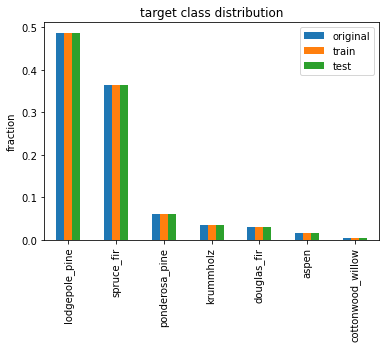

In [21]:
for_plot = ['target_name', 'original', 'train', 'test']
_ = df_target_dist[for_plot].set_index('target_name').plot.bar();
_ = plt.title('target class distribution');
_ = plt.xlabel('')
_ = plt.ylabel('fraction')

# `pycaret` `setup`
### `silent = True` to supress interactive confirmation of data types
### `tuple` returned by `setup` has `DataFrames` at these locations
`[29]` is all rows,   original columns (not transformed)   
`[25]` is all rows,   columns transformed   
`[33]` is train rows, columns transformed   
`[ 8]` is test rows,  columns transformed   
bizarre--locations seem to depend on `setup arg` values

In [22]:
def print_data_preprocess_columns_from_setup(setup_result):
    pp(setup_result[25].columns)

def print_dataframes_from_setup(setup_result):
    for item in range(len(setup_result)):
        if str(type(setup_result[item])).find('DataFrame') > 0:
            print('item=', item, 'type=', type(setup_result[item]), setup_result[item].shape)
            #print(su_one_hot[item].head())

In [23]:
#su_log_profile = True
su_log_profile = False

su_silent = True
#su_silent = False

# `pycaret` metrics and models
### models
- logistic regression
- decision tree
- XGBoost
- LightGBM (use categorical features directly)
- CatBoost (use categorical features directly)

In [24]:
def specify_metrics():
    get_metrics(reset=True)

    delete_metrics = ['auc', 'recall', 'kappa', 'mcc']
    for item in delete_metrics:
        remove_metric(item)

    _ = add_metric('re_wgt', 'Recall Weighted', recall_score, average='weighted')

    _ = add_metric('pr_macro', 'Precision Macro', precision_score, average='macro')
    _ = add_metric('re_macro', 'Recall Macro', recall_score, average='macro')
    _ = add_metric('f1_macro', 'F1 Macro', f1_score, average='macro')

In [25]:
models_to_run = ['lr', 'dt', 'xgboost', 'lightgbm', 'catboost']

# experiment 1
### min-max scale; 1-hot wild; 1-hot soil
### `setup`

In [26]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='none')
features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'cover_type']

['wilderness_index', 'soil_index']

In [27]:
su_one_hot = setup(data = df_data_to_use[cols_to_use], target = target_col[0],
                   categorical_features = features_cat,
                   normalize = True, normalize_method = 'minmax',
                   train_size = 0.7, fold = 3, session_id = 59,
                   log_experiment = True, experiment_name = 'soil one hot', log_profile = su_log_profile,
                   #profile = True
                   silent = su_silent
                   )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
#print_dataframes_from_setup(su_one_hot)

In [29]:
#su_one_hot[38].columns
#su_one_hot[38].head()

In [30]:
#su_one_hot[27].columns
#su_one_hot[27].head()

### `compare_models`

In [31]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd814350820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7fd814359550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7fd814359040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [32]:
models_one_hot = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9210,0.9210,0.9210,0.9210,0.8774,0.8745,0.8759,2.7400
catboost,CatBoost Classifier,0.8796,0.8796,0.8787,0.8796,0.8756,0.8116,0.8381,93.2900
xgboost,Extreme Gradient Boosting,0.8680,0.8682,0.8672,0.8680,0.8844,0.8235,0.8484,169.0933
lightgbm,Light Gradient Boosting Machine,0.8562,0.8562,0.8556,0.8562,0.8488,0.8116,0.8273,11.5333
lr,Logistic Regression,0.7245,0.7120,0.7139,0.7245,0.5913,0.4993,0.5194,73.9133


In [33]:
models_one_hot

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=59, splitter='best'),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
               objective='multi:softprob', random_state=59, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
     

### investigate results

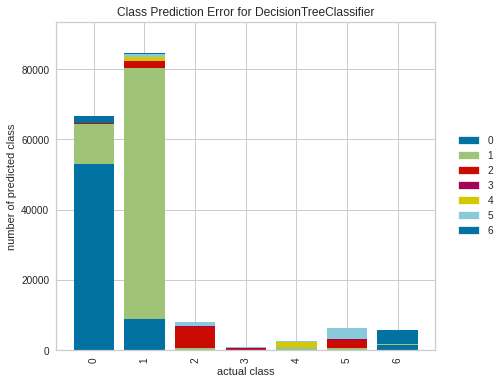

In [34]:
plot_model(models_one_hot[0], plot='error')

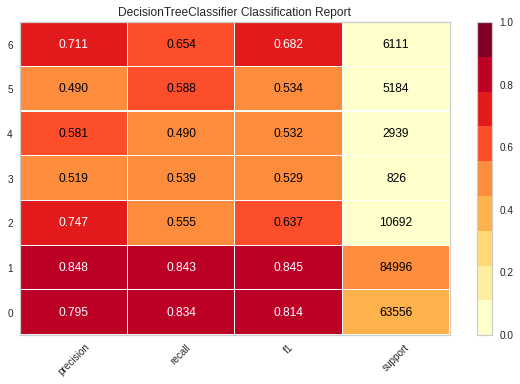

In [35]:
plot_model(models_one_hot[0], plot='class_report')

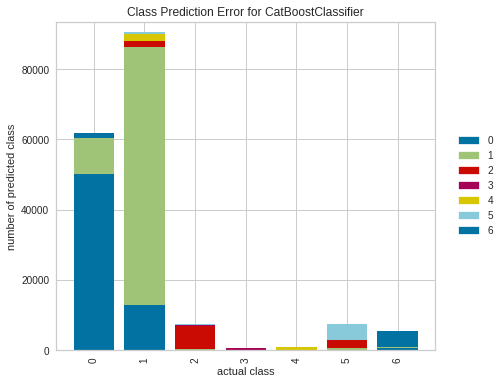

In [36]:
plot_model(models_one_hot[1], plot='error')

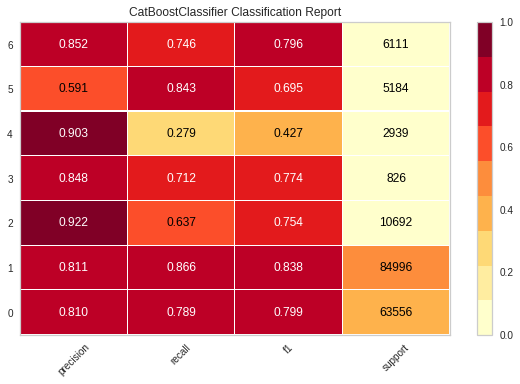

In [37]:
plot_model(models_one_hot[1], plot='class_report')

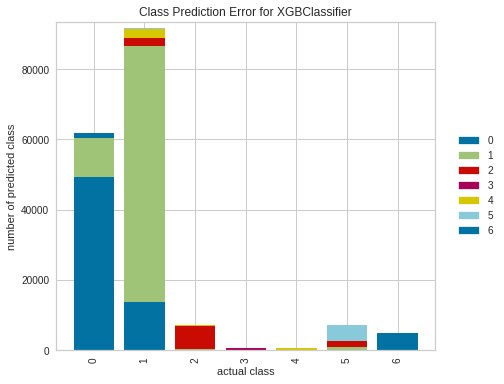

In [38]:
plot_model(models_one_hot[2], plot='error')

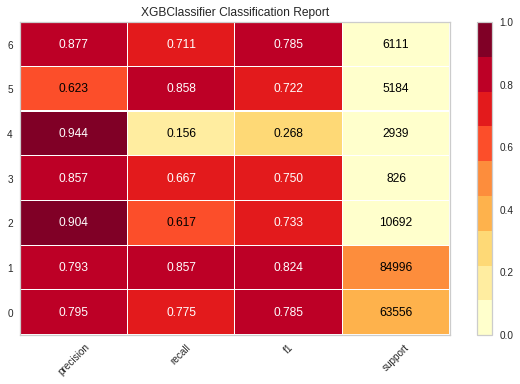

In [39]:
plot_model(models_one_hot[2], plot='class_report')

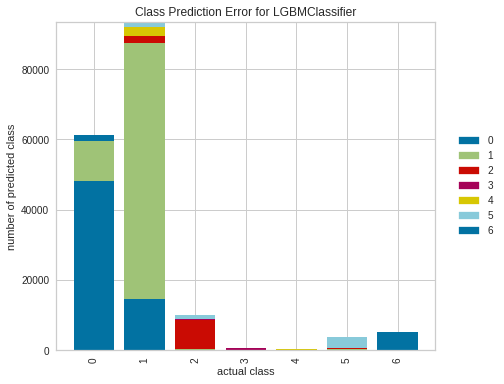

In [40]:
plot_model(models_one_hot[3], plot='error')

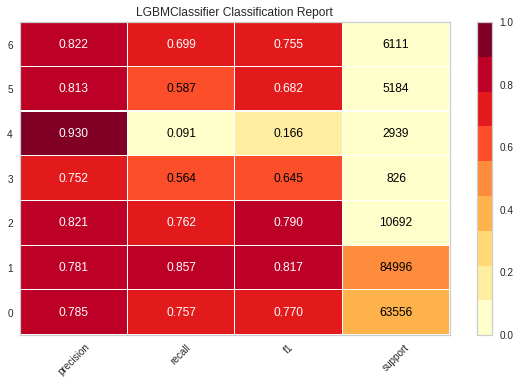

In [41]:
plot_model(models_one_hot[3], plot='class_report')

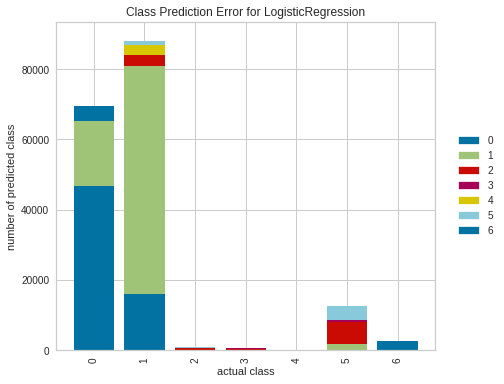

In [42]:
plot_model(models_one_hot[4], plot='error')

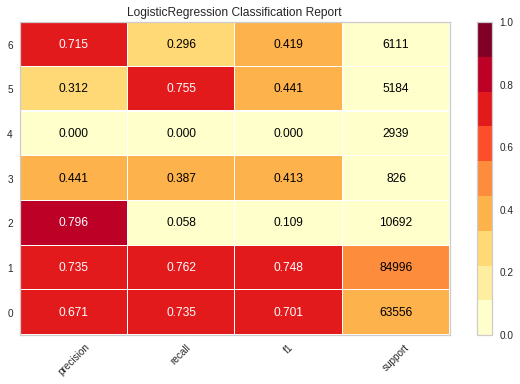

In [43]:
plot_model(models_one_hot[4], plot='class_report')

# experiment 2
### min-max scale; 1-hot wild; frequency soil

In [44]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='none')
features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'cover_type']

['wilderness_index', 'soil_index']

In [45]:
su_soil_freq = setup(data = df_data_to_use[cols_to_use], target = target_col[0],
                     categorical_features = features_cat,
                     normalize = True, normalize_method = 'minmax',
                     high_cardinality_features = ['soil_index'], high_cardinality_method = 'frequency',
                     train_size = 0.7, fold = 3, session_id = 59,
                     log_experiment = True, experiment_name = 'soil frequency', log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,True


In [46]:
#print_dataframes_from_setup(su_soil_freq)

In [47]:
#su_soil_freq[38].columns
#su_soil_freq[38].head(5)

In [48]:
#su_soil_freq[27].columns
#su_soil_freq[27].head(5)

In [49]:
#su_soil_freq[27].shape
#su_soil_freq[27]['soil_index'].value_counts()

In [50]:
#su_soil_freq[9].columns
#su_soil_freq[9].head()

In [51]:
#su_soil_freq[9].shape
#su_soil_freq[9]['soil_index'].value_counts()

### `compare_models`

In [52]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd814350820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7fd814359550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7fd814359040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [53]:
models_freq = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9183,0.9183,0.9183,0.9183,0.8720,0.8692,0.8705,2.1367
catboost,CatBoost Classifier,0.8819,0.8819,0.8810,0.8819,0.8794,0.8128,0.8403,102.0100
xgboost,Extreme Gradient Boosting,0.8763,0.8764,0.8756,0.8763,0.8874,0.8280,0.8528,127.6433
lightgbm,Light Gradient Boosting Machine,0.8543,0.8542,0.8536,0.8543,0.8407,0.8033,0.8188,11.8433
lr,Logistic Regression,0.7085,0.6920,0.6956,0.7085,0.5630,0.4323,0.4602,52.3400


### investigate results

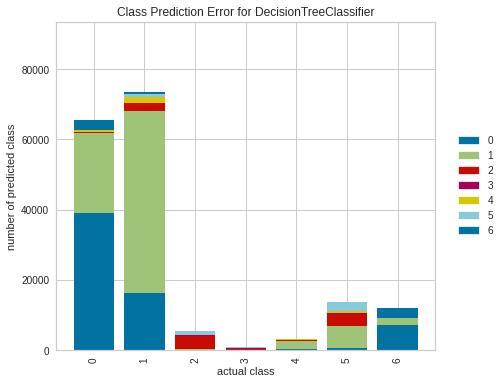

In [54]:
plot_model(models_freq[0], plot='error')

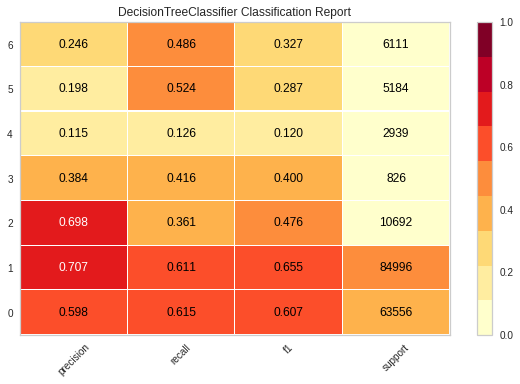

In [55]:
plot_model(models_freq[0], plot='class_report')

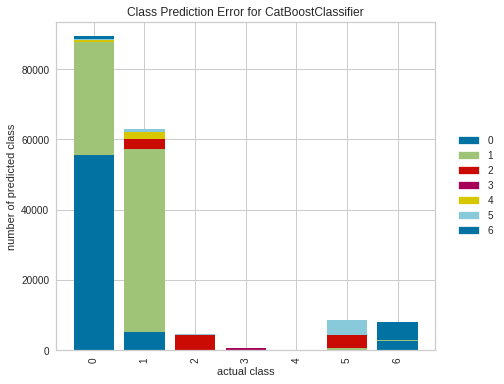

In [56]:
plot_model(models_freq[1], plot='error')

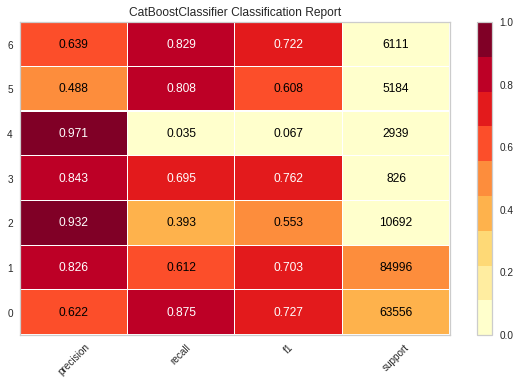

In [57]:
plot_model(models_freq[1], plot='class_report')

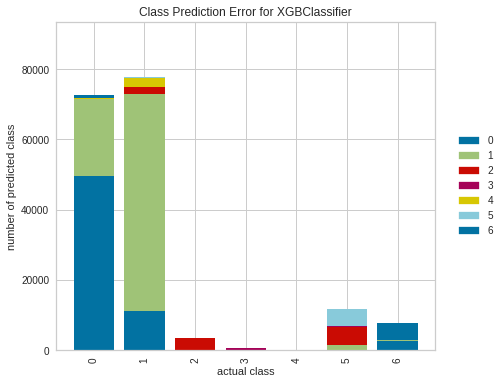

In [58]:
plot_model(models_freq[2], plot='error')

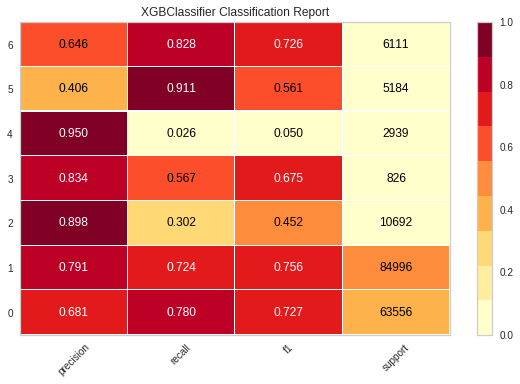

In [59]:
plot_model(models_freq[2], plot='class_report')

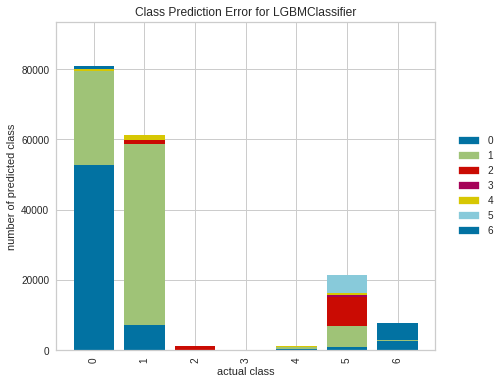

In [60]:
plot_model(models_freq[3], plot='error')

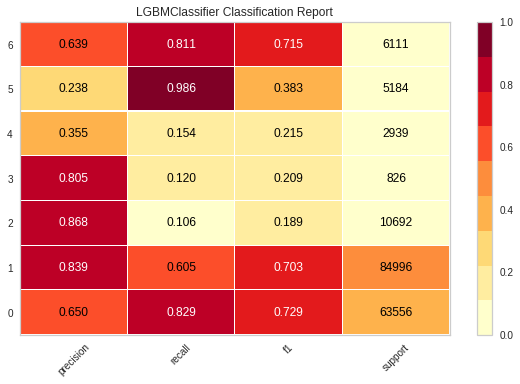

In [61]:
plot_model(models_freq[3], plot='class_report')

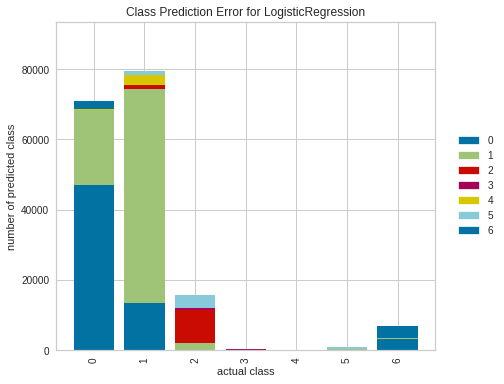

In [62]:
plot_model(models_freq[4], plot='error')

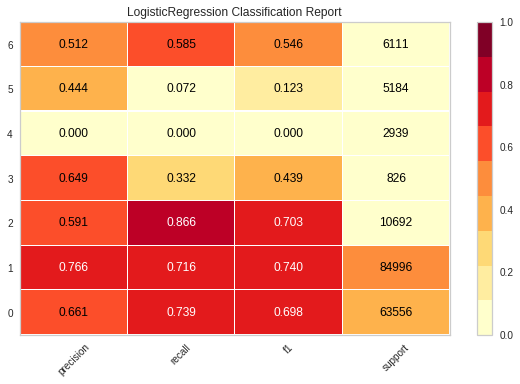

In [63]:
plot_model(models_freq[4], plot='class_report')

# experiment 3
### min-max scale; 1-hot wild; climatic soil

In [64]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='climatic')
features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'climatic_zone',
 'cover_type']

['wilderness_index', 'climatic_zone']

In [65]:
su_soil_climatic = setup(data = df_data_to_use[cols_to_use], target = target_col[0],
                         categorical_features = features_cat,
                         normalize = True, normalize_method = 'minmax',
                         train_size = 0.7, fold = 3, session_id = 59,
                         log_experiment = True, experiment_name = 'soil climatic clusters', log_profile = su_log_profile,
                         #profile = True
                         silent = su_silent
                         )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [66]:
#print_dataframes_from_setup(su_soil_climatic)

In [67]:
#su_soil_climatic[38].columns
#su_soil_climatic[38].head(5)

In [68]:
#su_soil_climatic[27].columns
#su_soil_climatic[27].head(5)

### `compare_models`

In [69]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd814350820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7fd814359550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7fd814359040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [70]:
models_climatic = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9116,0.9115,0.9115,0.9116,0.8649,0.8602,0.8625,2.1967
catboost,CatBoost Classifier,0.8700,0.8701,0.8690,0.8700,0.8723,0.8016,0.8301,98.8700
xgboost,Extreme Gradient Boosting,0.8579,0.8581,0.8571,0.8579,0.8785,0.8128,0.8396,128.8600
lightgbm,Light Gradient Boosting Machine,0.8426,0.8424,0.8419,0.8426,0.8384,0.7903,0.8107,11.1400
lr,Logistic Regression,0.7151,0.6989,0.7032,0.7151,0.5639,0.4635,0.4846,60.0067


### investigate results

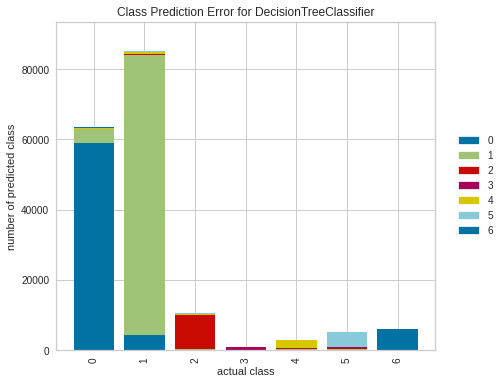

In [71]:
plot_model(models_climatic[0], plot='error')

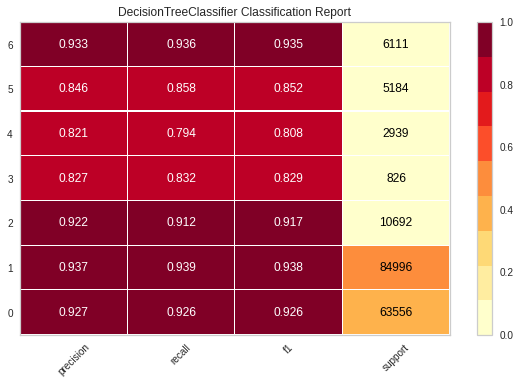

In [72]:
plot_model(models_climatic[0], plot='class_report')

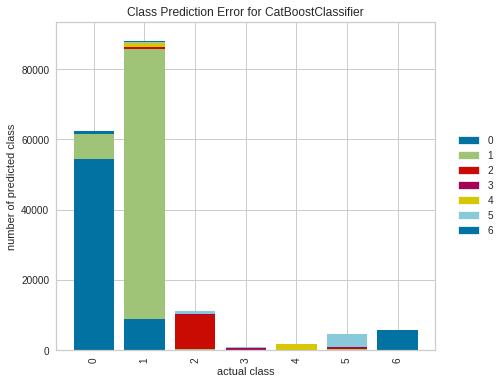

In [73]:
plot_model(models_climatic[1], plot='error')

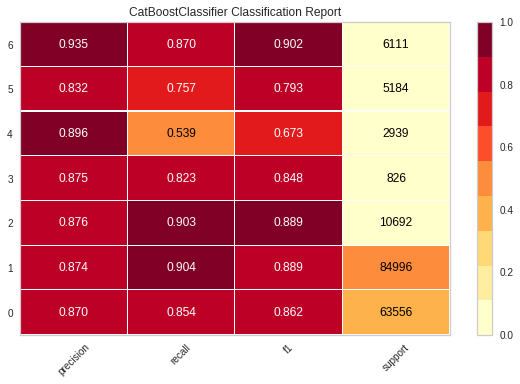

In [74]:
plot_model(models_climatic[1], plot='class_report')

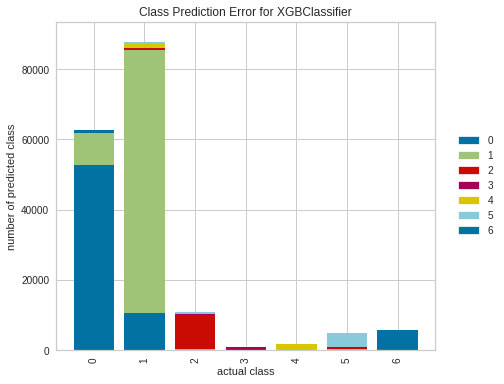

In [75]:
plot_model(models_climatic[2], plot='error')

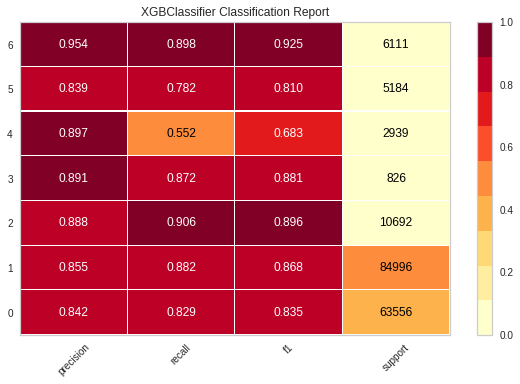

In [76]:
plot_model(models_climatic[2], plot='class_report')

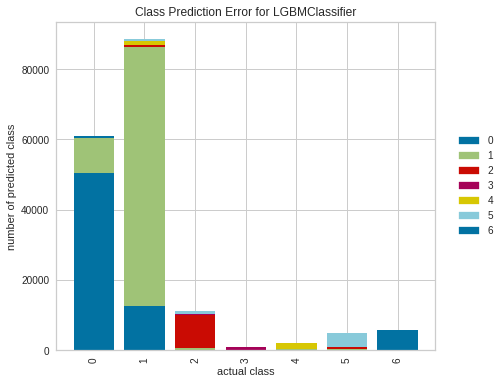

In [77]:
plot_model(models_climatic[3], plot='error')

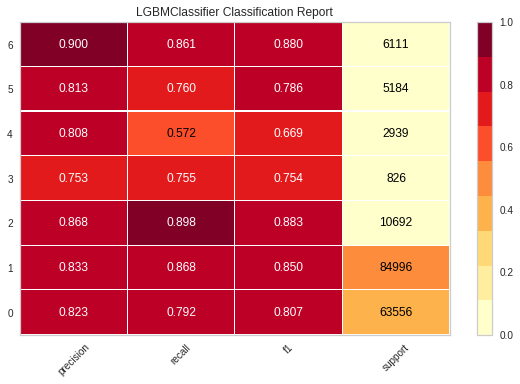

In [78]:
plot_model(models_climatic[3], plot='class_report')

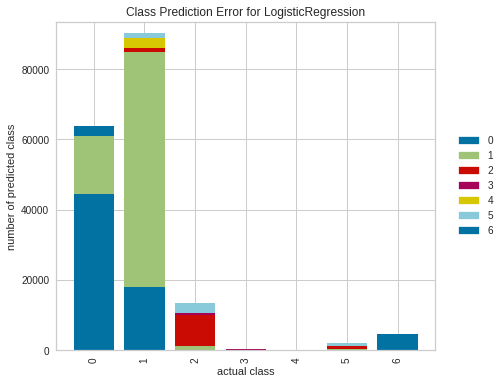

In [79]:
plot_model(models_climatic[4], plot='error')

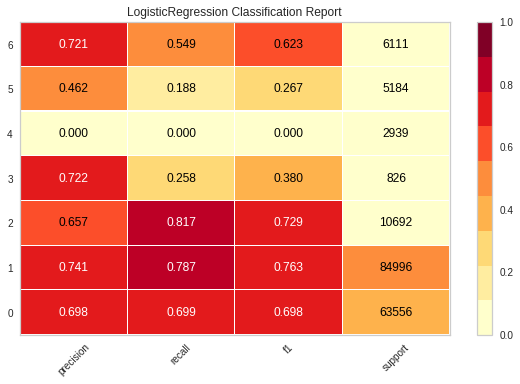

In [80]:
plot_model(models_climatic[4], plot='class_report')

# experiment 4
### min-max scale; 1-hot wild; geologic soil

In [81]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='geologic')
features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'geologic_zone',
 'cover_type']

['wilderness_index', 'geologic_zone']

In [82]:
su_soil_geologic = setup(data = df_data_to_use[cols_to_use], target = target_col[0],
                         categorical_features = features_cat,
                         normalize = True, normalize_method = 'minmax',
                         train_size = 0.7, fold = 3, session_id = 59,
                         log_experiment = True, experiment_name = 'soil geologic clusters', log_profile = su_log_profile,
                         #profile = True
                         silent = su_silent
                         )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [83]:
#print_dataframes_from_setup(su_soil_geologic)

In [84]:
#su_soil_geologic[38].columns
#su_soil_geologic[38].head(5)

In [85]:
#su_soil_geologic[27].columns
#su_soil_geologic[27].head(5)

### `compare_models`

In [86]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd814350820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7fd814359550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7fd814359040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [87]:
models_geologic = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9084,0.9084,0.9084,0.9084,0.8542,0.8525,0.8533,2.1400
catboost,CatBoost Classifier,0.8702,0.8704,0.8691,0.8702,0.8717,0.7928,0.8246,98.9000
xgboost,Extreme Gradient Boosting,0.8590,0.8593,0.8582,0.8590,0.8748,0.8060,0.8340,123.0033
lightgbm,Light Gradient Boosting Machine,0.8418,0.8420,0.8411,0.8418,0.8300,0.7798,0.7998,11.3267
lr,Logistic Regression,0.7092,0.6917,0.6956,0.7092,0.5467,0.4259,0.4526,57.3933


### investigate results

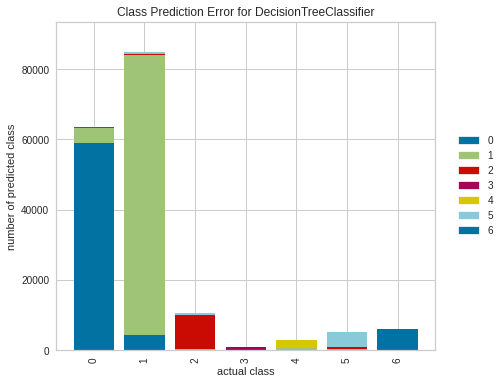

In [88]:
plot_model(models_geologic[0], plot='error')

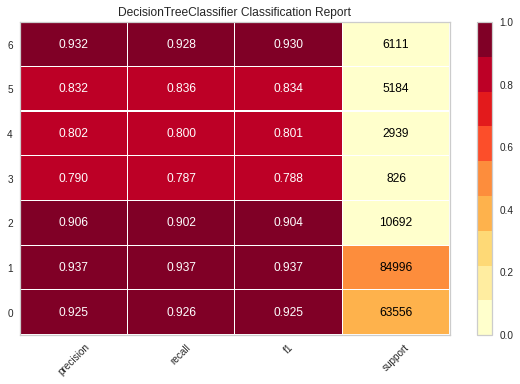

In [89]:
plot_model(models_geologic[0], plot='class_report')

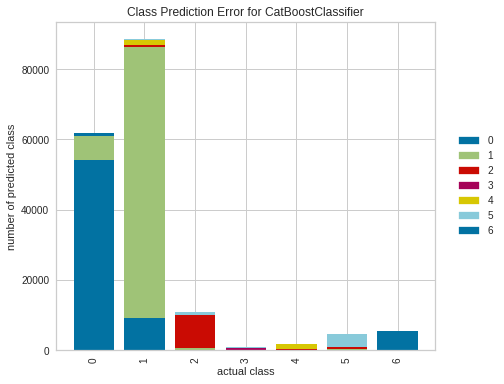

In [90]:
plot_model(models_geologic[1], plot='error')

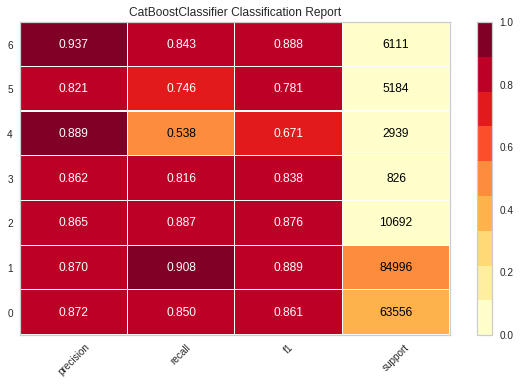

In [91]:
plot_model(models_geologic[1], plot='class_report')

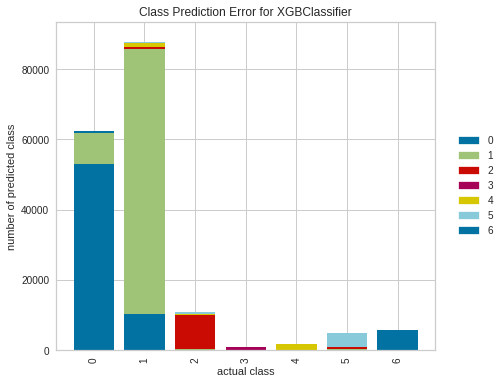

In [92]:
plot_model(models_geologic[2], plot='error')

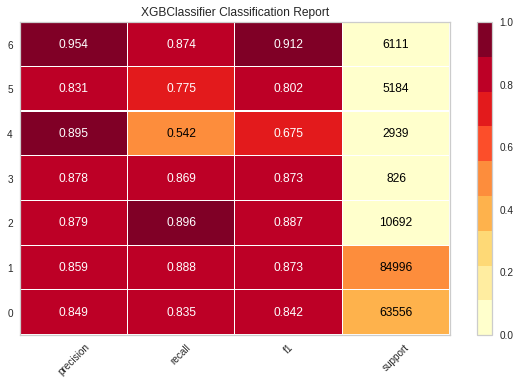

In [93]:
plot_model(models_geologic[2], plot='class_report')

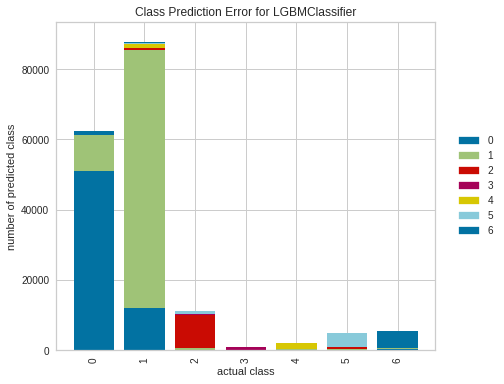

In [94]:
plot_model(models_geologic[3], plot='error')

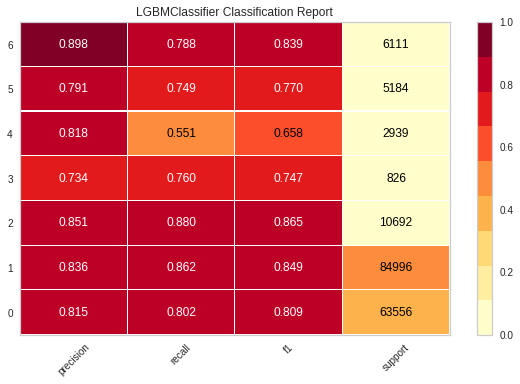

In [95]:
plot_model(models_geologic[3], plot='class_report')

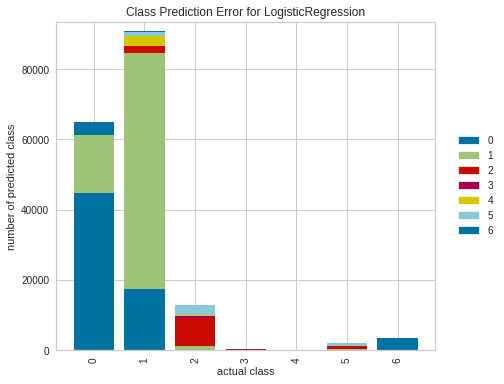

In [96]:
plot_model(models_geologic[4], plot='error')

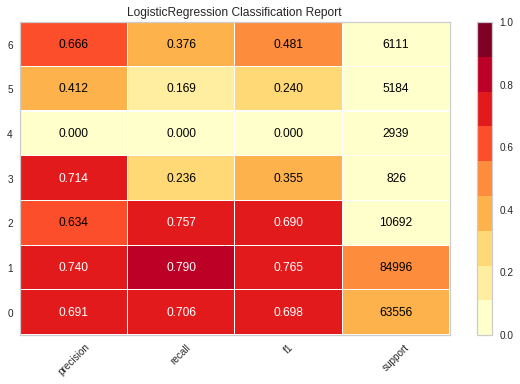

In [97]:
plot_model(models_geologic[4], plot='class_report')

# experiment 5
### min-max scale; 1-hot wild; both soil

In [98]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='both')
features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'both_zones',
 'cover_type']

['wilderness_index', 'both_zones']

In [99]:
su_soil_both = setup(data = df_data_to_use[cols_to_use], target = target_col[0],
                     categorical_features = features_cat,
                     normalize = True, normalize_method = 'minmax',
                     train_size = 0.7, fold = 3, session_id = 59,
                     log_experiment = True, experiment_name = 'soil both clusters', log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [100]:
#print_dataframes_from_setup(su_soil_both)

In [101]:
#su_soil_both[38].columns
#su_soil_both[38].head(5)

In [102]:
#su_soil_both[27].columns
#su_soil_both[27].head(5)

### `compare_models`

In [103]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd814350820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7fd814359550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7fd814359670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7fd814359040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [104]:
models_both = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9125,0.9125,0.9125,0.9125,0.8648,0.8613,0.8630,2.2667
catboost,CatBoost Classifier,0.8740,0.8741,0.8730,0.8740,0.8745,0.8054,0.8338,99.7200
xgboost,Extreme Gradient Boosting,0.8639,0.8640,0.8631,0.8639,0.8782,0.8151,0.8407,132.1967
lightgbm,Light Gradient Boosting Machine,0.8414,0.8412,0.8405,0.8414,0.8310,0.7857,0.8041,11.3100
lr,Logistic Regression,0.7191,0.7028,0.7069,0.7191,0.5656,0.4642,0.4856,60.6233


### investigate results

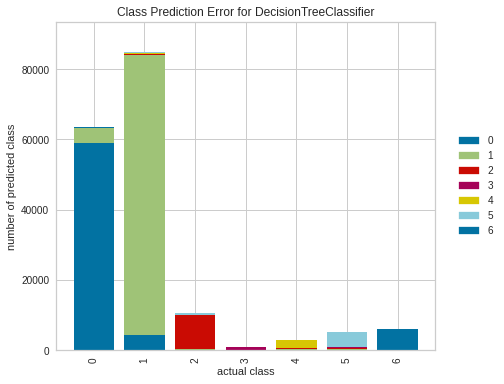

In [105]:
plot_model(models_both[0], plot='error')

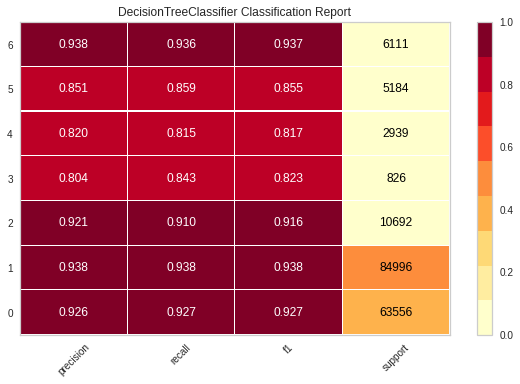

In [106]:
plot_model(models_both[0], plot='class_report')

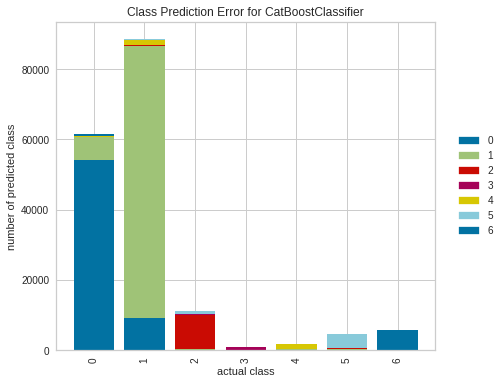

In [107]:
plot_model(models_both[1], plot='error')

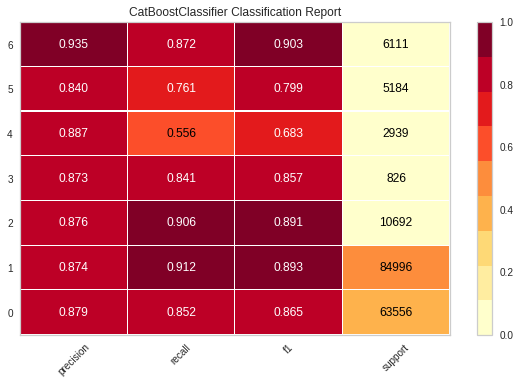

In [108]:
plot_model(models_both[1], plot='class_report')

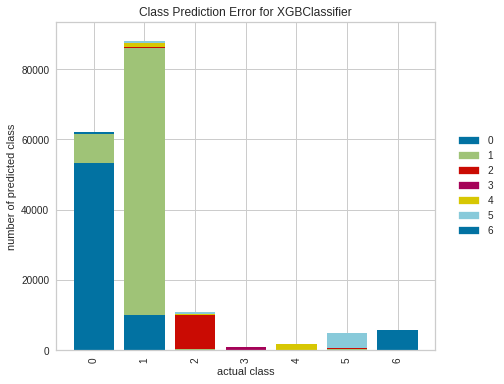

In [109]:
plot_model(models_both[2], plot='error')

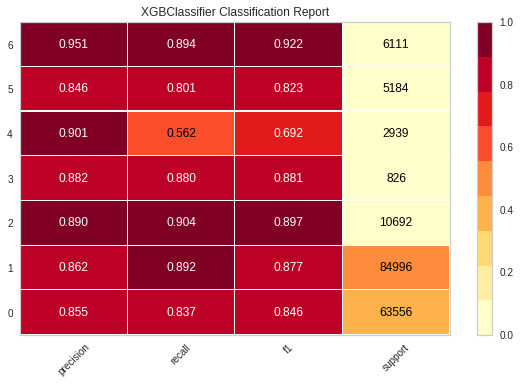

In [110]:
plot_model(models_both[2], plot='class_report')

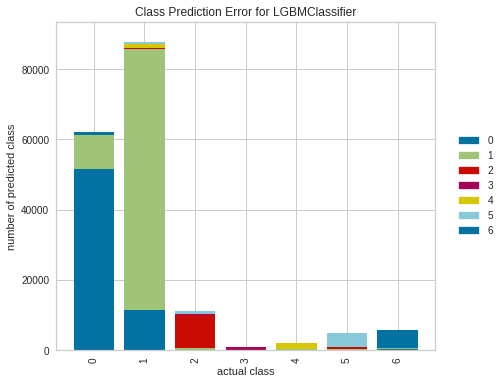

In [111]:
plot_model(models_both[3], plot='error')

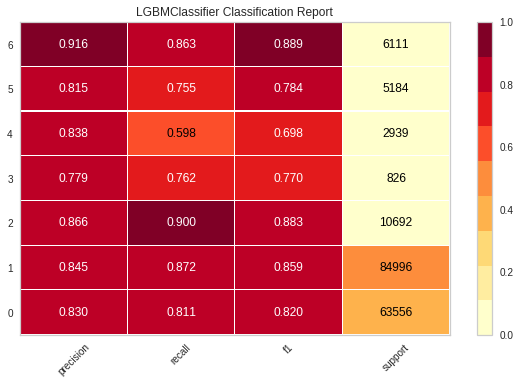

In [112]:
plot_model(models_both[3], plot='class_report')

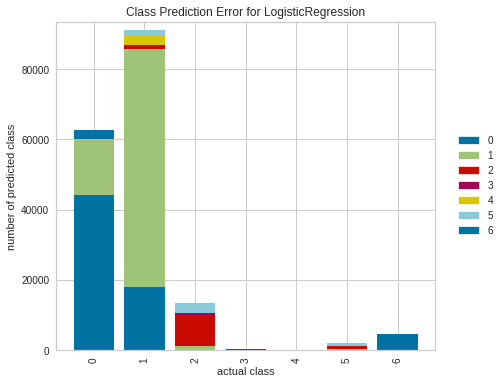

In [113]:
plot_model(models_both[4], plot='error')

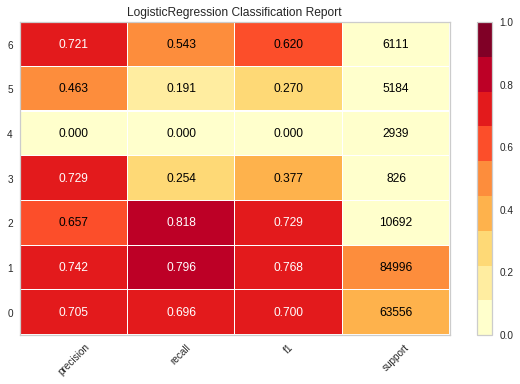

In [114]:
plot_model(models_both[4], plot='class_report')